# Group Project on Risk Factors of Heart Attack
**Aparna Varma, Ariel Chen, Edurado Mejia, Frank Zhang**

### 1. Introduction 

&ensp; &ensp; &ensp;Historically, heart attacks have been one of the biggest problems that humans have had to deal with when looking at their health. There are various factors influencing the probability of getting heart attacks like age, sex… Some factors are what we are born with and can not control, but some are things we can change by having a healthier lifestyle. In this project, we will specifically look at the question:  “Given the cholesterol and resting blood pressure of an individual, is it possible to predict if that individual has a higher chance of having a heart attack?”  We will study this problem by investging the dataset in https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset, by evaluating and analyzing the relationship between cholesterol, resting blood pressure and heart attacks for individuals. The data set uses many variables, including these two as well as ECG data and other identifiers such as anginas (a type of chest pain) to predict the chance of a heart attack. 
    


### 2. Analysis

&ensp; &ensp; &ensp; The goal of this analysis is to predict and visualize an individual’s chance of getting a heart attack at some point in their lives. Using the data set that we have obtained, we will use classification for K-nearest neighbours to train and test our model. 

&ensp; &ensp; &ensp;The variables that we will use are resting blood pressure (trtbps, mmHg), cholesterol (chol, mg/dl), and the output (0 for low chance, 1 for a high chance). We can visualize our data by standardizing both variables (blood pressure and cholesterol) and making the output variable define their color. 

&ensp; &ensp; &ensp;To run our analysis the data will be split into a training and test set, and a cross-validation will be performed to test the accuracy of our model. We will use tune_grid to allow us to compare our knn variables and find the appropriate neighbors value. 

&ensp; &ensp; &ensp;We can visualize our results by printing out a confusion matrix to easily interpret how our model performed by seeing how many observations are labeled correctly. We can perform further analysis into seeing the strength of our model by testing it on historical data of individuals that have had heart attacks (using cholesterol and blood pressure data alone). 


### 3. Expected outcomes

&ensp; &ensp; &ensp;From this project we expect to establish if it is possible to predict the chance of a heart attack from an individual’s cholesterol and blood pressure levels. We expect to find a model that can reasonably predict the chance of a heart attack, although we concede that there are many more factors that affect our result such as age, sex, histroy of anginas, fasting blood sugar, ecg scans, and more.  By obtaining a predictive model, we can give people an idea on what lifestyle changes they can make to lower their chance of heart diseases. This can also impose future questions for the governing health bodies such as BC’s ministry of health for how they can educate younger individuals in ways to improve people's lifestyles so that they can avoid heart diseases as they grow older. 


### 4. Preliminary exploratory data analysis

All preliminary exploratories done on the data set is included in the code below. Key explanations of the code are included as annotations.

In [75]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [76]:
url <- "https://raw.githubusercontent.com/Fr4nXxx/toy_ds_project/main/heart.csv"
download.file(url,destfile = "data/HeartAttackData.csv")
heart_data <- read_csv("data/HeartAttackData.csv") %>%
    mutate(sex = as_factor(sex), cp = as_factor(cp), exng = as_factor(exng), output = as_factor(output)) 
    #to convert all factors that were read as numeric values into factors
heart_data
tibble(number_of_rows = nrow(heart_data)) # to show how many rows are there in the data set
heart_data_summary <- heart_data %>%
    select(-sex, -cp, -exng, -output) %>%
    map_df(mean) 
    #calculating the mean for all non-factor columns
heart_data_summary

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trtbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalachh = col_double(),
  exng = col_double(),
  oldpeak = col_double(),
  slp = col_double(),
  caa = col_double(),
  thall = col_double(),
  output = col_double()
)



age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


number_of_rows
<int>
303


age,trtbps,chol,fbs,restecg,thalachh,oldpeak,slp,caa,thall
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.36634,131.6238,246.264,0.1485149,0.5280528,149.6469,1.039604,1.39934,0.7293729,2.313531


In [77]:
set.seed(10000) # setting the seed for splitting the data set

heart_split <- initial_split(heart_data, prop = 0.75, strata = output) #use 75% of the data as the training set
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

#graph_1 <- heart_train %>%
#    ggplot(aes(x = age, y = trtbps)) + #plotting a graph of blood pressure vs. age
#    geom_point() +
#    labs(x = "Age", y = "Resting blood pressure (mmHg)") + 
#    ggtitle("Resting blood pressure in mmHg vs. Age") +
#    theme(text = element_text(size = 15))
#graph_1

heart_train <- heart_train %>%
    select(chol, trtbps, output)
heart_test <- heart_test %>%
    select(chol, trtbps, output)

heart_recipe <- recipe(output ~., data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

number_vfold <- vfold_cv(heart_train, v = 5, strata = output)

knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = number_vfold, grid = 10) %>%
       collect_metrics()

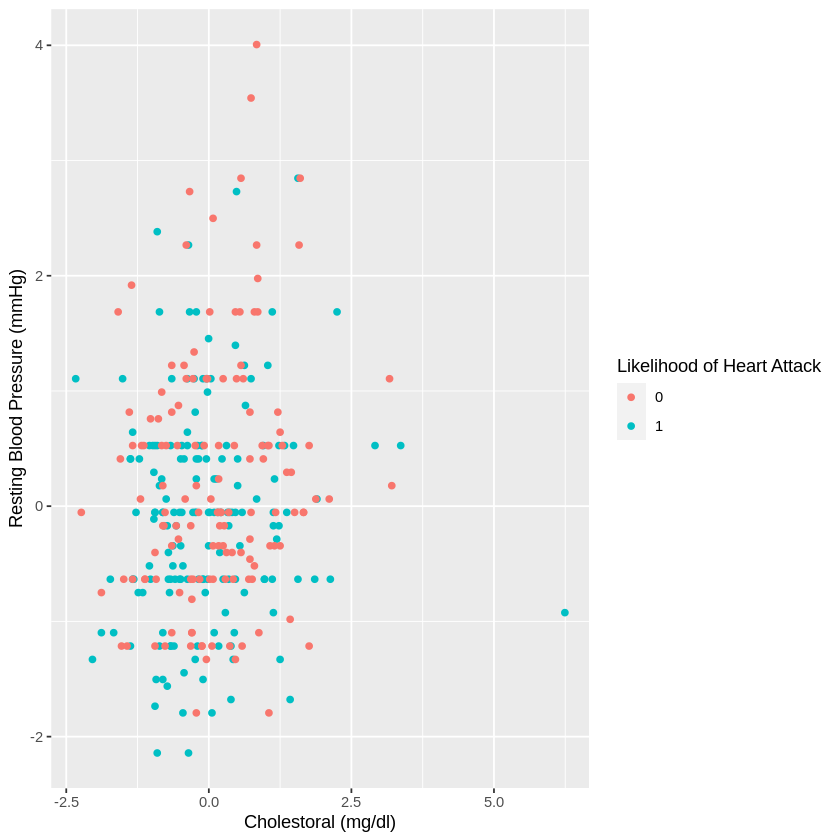

In [78]:
heart_data_scaled <- heart_recipe %>%  
    prep() %>% 
    bake(heart_data)
heart_plot <- heart_data_scaled %>%
    ggplot(aes(x = chol, y = trtbps)) +
    geom_point(aes(color = output)) +
    labs (x = "Cholestoral (mg/dl)", y = "Resting Blood Pressure (mmHg)", color = "Likelihood of Heart Attack")
heart_plot

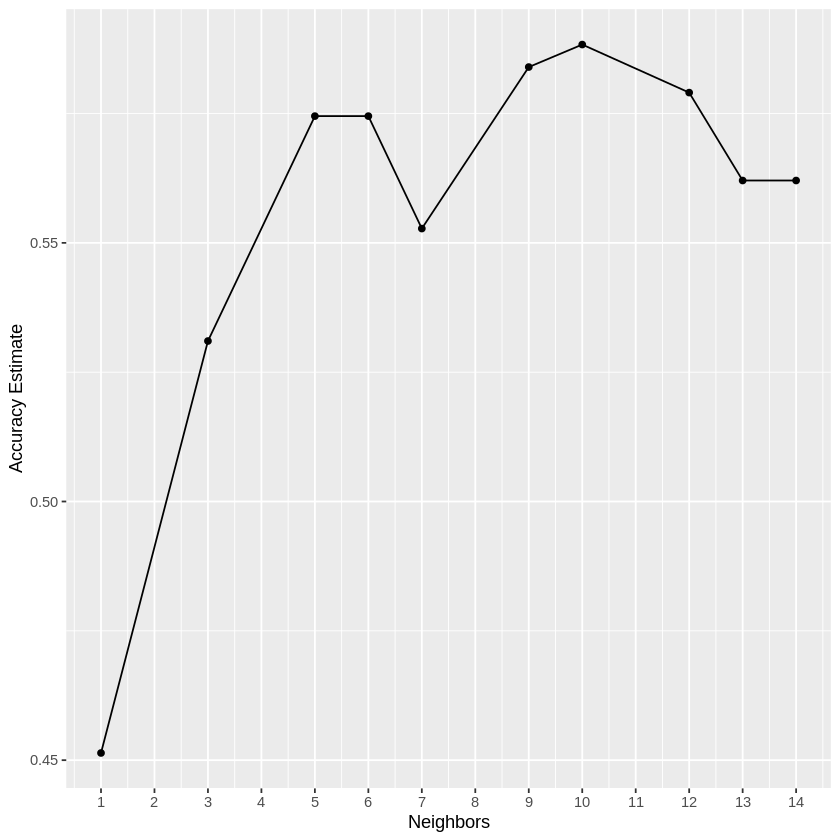

In [79]:
accuracies <- knn_results %>% 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") + 
       scale_x_continuous(breaks = seq(0, 14, by = 1)) # adjusting the x-axis
cross_val_plot

k <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors) 

In [80]:
heart_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_fit <- workflow() %>%
        add_recipe(heart_recipe)%>%
        add_model(heart_spec_10) %>%
        fit(data = heart_train)

heart_predictions <- predict (heart_fit, heart_test) %>%
    bind_cols(heart_test)

heart_metrics <- mnist_predictions %>%
    metrics(truth = output, estimate = .pred_class)

heart_conf_mat <- mnist_predictions %>% 
    conf_mat(truth = output, estimate = .pred_class)

heart_predictions
heart_metrics

.pred_class,chol,trtbps,output
<fct>,<dbl>,<dbl>,<fct>
1,233,145,1
0,250,130,1
1,204,130,1
⋮,⋮,⋮,⋮
1,318,114,0
1,187,140,0
0,193,144,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.46666667
kap,binary,-0.07604017
